# ML Assignment 2: Adult Income Classification Models
## Student ID: 2025aa05627

This notebook implements and compares 6 classification models on the Adult dataset to predict income levels (<=50K or >50K).

**Models to implement:**
1. Logistic Regression
2. Decision Tree Classifier
3. K-Nearest Neighbors (KNN)
4. Naive Bayes
5. Random Forest
6. XGBoost

**Evaluation Metrics:** Accuracy, AUC Score, Precision, Recall, F1 Score, Matthews Correlation Coefficient (MCC)

## Section 1: Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, precision_score, 
                             recall_score, f1_score, matthews_corrcoef,
                             confusion_matrix, classification_report)
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## Section 2: Load and Explore the Adult Dataset

In [2]:
# Load the dataset
df = pd.read_csv('adult.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nStatistical Summary:")
print(df.describe())

Dataset Shape: (48842, 15)

First few rows:
   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             

Target Variable Distribution:
income
<=50K    37155
>50K     11687
Name: count, dtype: int64

Target Variable Distribution (%):
income
<=50K    76.071823
>50K     23.928177
Name: proportion, dtype: float64


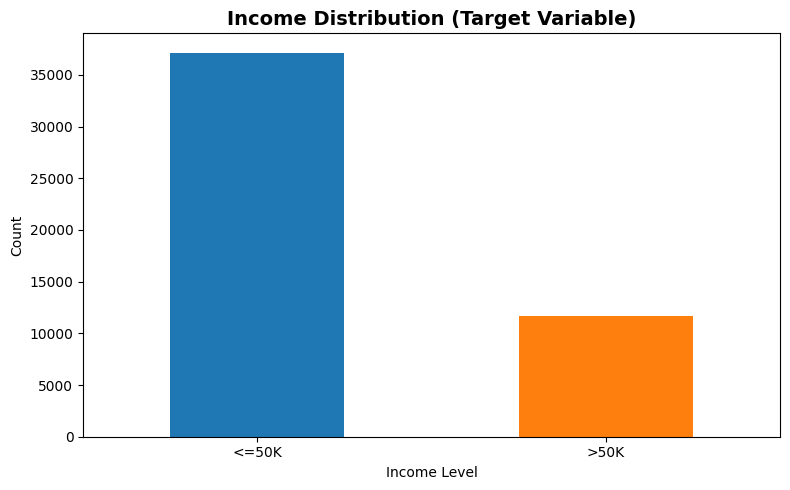

In [3]:
# Explore target variable distribution
print("Target Variable Distribution:")
print(df['income'].value_counts())
print("\nTarget Variable Distribution (%):")
print(df['income'].value_counts(normalize=True) * 100)

# Visualize target distribution
plt.figure(figsize=(8, 5))
df['income'].value_counts().plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title('Income Distribution (Target Variable)', fontsize=14, fontweight='bold')
plt.xlabel('Income Level')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Section 3: Data Preprocessing and Feature Engineering

In [4]:
# Make a copy for preprocessing
data = df.copy()

# Handle missing values (represented as '?')
print("Handling missing values...")
data = data[~((data == '?').any(axis=1))]
print(f"Dataset shape after removing '?': {data.shape}")

# Separate features and target
X = data.drop('income', axis=1)
y = data['income']

# Encode target variable
print("\nEncoding target variable...")
le_target = LabelEncoder()
y = le_target.fit_transform(y)  # <=50K = 0, >50K = 1
print(f"Target encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

print(f"\nCategorical columns: {list(categorical_cols)}")
print(f"Numerical columns: {list(numerical_cols)}")

# Encode categorical variables
print("\nEncoding categorical variables...")
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

print("✓ Data preprocessing completed!")

Handling missing values...
Dataset shape after removing '?': (45222, 15)

Encoding target variable...
Target encoding: {'<=50K': np.int64(0), '>50K': np.int64(1)}

Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
Numerical columns: ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Encoding categorical variables...
✓ Data preprocessing completed!


## Section 4: Split Data into Training and Testing Sets

In [5]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")
print(f"\nTraining set target distribution:\n{pd.Series(y_train).value_counts()}")
print(f"\nTesting set target distribution:\n{pd.Series(y_test).value_counts()}")

Training set size: 36177
Testing set size: 9045
Number of features: 14

Training set target distribution:
0    27211
1     8966
Name: count, dtype: int64

Testing set target distribution:
0    6803
1    2242
Name: count, dtype: int64


## Helper Function: Calculate All 6 Metrics

In [6]:
def calculate_metrics(y_true, y_pred, y_pred_proba=None):
    """Calculate all 6 evaluation metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    # AUC requires probabilities
    if y_pred_proba is not None:
        auc = roc_auc_score(y_true, y_pred_proba)
    else:
        auc = roc_auc_score(y_true, y_pred)
    
    return {
        'Accuracy': accuracy,
        'AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'MCC': mcc
    }

# Dictionary to store all models and their results
models_results = {}
print("✓ Metrics calculation function defined!")

✓ Metrics calculation function defined!


## Section 5: Implement Logistic Regression

In [7]:
print("="*60)
print("1. LOGISTIC REGRESSION")
print("="*60)

# Train Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr.predict(X_test_scaled)
y_pred_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
metrics_lr = calculate_metrics(y_test, y_pred_lr, y_pred_proba_lr)
models_results['Logistic Regression'] = metrics_lr

print("\nLogistic Regression Results:")
for metric, value in metrics_lr.items():
    print(f"  {metric}: {value:.4f}")
print("✓ Logistic Regression completed!")

1. LOGISTIC REGRESSION

Logistic Regression Results:
  Accuracy: 0.8172
  AUC: 0.8473
  Precision: 0.7075
  Recall: 0.4478
  F1: 0.5485
  MCC: 0.4592
✓ Logistic Regression completed!


## Section 6: Implement Decision Tree Classifier

In [8]:
print("="*60)
print("2. DECISION TREE CLASSIFIER")
print("="*60)

# Train Decision Tree
dt = DecisionTreeClassifier(max_depth=15, random_state=42)
dt.fit(X_train, y_train)

# Predictions
y_pred_dt = dt.predict(X_test)
y_pred_proba_dt = dt.predict_proba(X_test)[:, 1]

# Calculate metrics
metrics_dt = calculate_metrics(y_test, y_pred_dt, y_pred_proba_dt)
models_results['Decision Tree'] = metrics_dt

print("\nDecision Tree Results:")
for metric, value in metrics_dt.items():
    print(f"  {metric}: {value:.4f}")
print("✓ Decision Tree completed!")

2. DECISION TREE CLASSIFIER

Decision Tree Results:
  Accuracy: 0.8416
  AUC: 0.8543
  Precision: 0.6974
  Recall: 0.6374
  F1: 0.6660
  MCC: 0.5635
✓ Decision Tree completed!


## Section 7: Implement K-Nearest Neighbors (KNN)

In [9]:
print("="*60)
print("3. K-NEAREST NEIGHBORS (KNN)")
print("="*60)

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predictions
y_pred_knn = knn.predict(X_test_scaled)
y_pred_proba_knn = knn.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
metrics_knn = calculate_metrics(y_test, y_pred_knn, y_pred_proba_knn)
models_results['KNN'] = metrics_knn

print("\nKNN Results:")
for metric, value in metrics_knn.items():
    print(f"  {metric}: {value:.4f}")
print("✓ KNN completed!")

3. K-NEAREST NEIGHBORS (KNN)

KNN Results:
  Accuracy: 0.8210
  AUC: 0.8455
  Precision: 0.6597
  Recall: 0.5740
  F1: 0.6139
  MCC: 0.5001
✓ KNN completed!


## Section 8: Implement Naive Bayes Classifier

In [10]:
print("="*60)
print("4. NAIVE BAYES CLASSIFIER")
print("="*60)

# Train Naive Bayes
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

# Predictions
y_pred_nb = nb.predict(X_test_scaled)
y_pred_proba_nb = nb.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
metrics_nb = calculate_metrics(y_test, y_pred_nb, y_pred_proba_nb)
models_results['Naive Bayes'] = metrics_nb

print("\nNaive Bayes Results:")
for metric, value in metrics_nb.items():
    print(f"  {metric}: {value:.4f}")
print("✓ Naive Bayes completed!")

4. NAIVE BAYES CLASSIFIER

Naive Bayes Results:
  Accuracy: 0.7947
  AUC: 0.8478
  Precision: 0.6717
  Recall: 0.3359
  F1: 0.4478
  MCC: 0.3692
✓ Naive Bayes completed!


## Section 9: Implement Random Forest Classifier

In [11]:
print("="*60)
print("5. RANDOM FOREST CLASSIFIER")
print("="*60)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

# Calculate metrics
metrics_rf = calculate_metrics(y_test, y_pred_rf, y_pred_proba_rf)
models_results['Random Forest'] = metrics_rf

print("\nRandom Forest Results:")
for metric, value in metrics_rf.items():
    print(f"  {metric}: {value:.4f}")
print("✓ Random Forest completed!")

5. RANDOM FOREST CLASSIFIER

Random Forest Results:
  Accuracy: 0.8616
  AUC: 0.9145
  Precision: 0.7735
  Recall: 0.6244
  F1: 0.6910
  MCC: 0.6089
✓ Random Forest completed!


## Section 10: Implement XGBoost Classifier

In [12]:
print("="*60)
print("6. XGBOOST CLASSIFIER")
print("="*60)

# Train XGBoost
xgb = XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.1, 
                    random_state=42, eval_metric='logloss', verbosity=0)
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# Calculate metrics
metrics_xgb = calculate_metrics(y_test, y_pred_xgb, y_pred_proba_xgb)
models_results['XGBoost'] = metrics_xgb

print("\nXGBoost Results:")
for metric, value in metrics_xgb.items():
    print(f"  {metric}: {value:.4f}")
print("✓ XGBoost completed!")

6. XGBOOST CLASSIFIER

XGBoost Results:
  Accuracy: 0.8668
  AUC: 0.9265
  Precision: 0.7722
  Recall: 0.6561
  F1: 0.7094
  MCC: 0.6272
✓ XGBoost completed!


## Section 11: Create Performance Metrics Table and Comparison

In [14]:
print("\n" + "="*100)
print("FINAL RESULTS: ALL MODELS COMPARISON")
print("="*100 + "\n")

# Create comparison DataFrame
results_df = pd.DataFrame(models_results).T
results_df = results_df.round(4)

print(results_df)
print("\nMetrics Table (For Report):")
print(results_df.to_string())

# Find best model for each metric
print("\n" + "="*80)
print("BEST MODELS BY METRIC:")
print("="*80)
for col in results_df.columns:
    best_model = results_df[col].idxmax()
    best_value = results_df[col].max()
    print(f"  {col:12s}: {best_model:20s} ({best_value:.4f})")


FINAL RESULTS: ALL MODELS COMPARISON

                     Accuracy     AUC  Precision  Recall      F1     MCC
Logistic Regression    0.8172  0.8473     0.7075  0.4478  0.5485  0.4592
Decision Tree          0.8416  0.8543     0.6974  0.6374  0.6660  0.5635
KNN                    0.8210  0.8455     0.6597  0.5740  0.6139  0.5001
Naive Bayes            0.7947  0.8478     0.6717  0.3359  0.4478  0.3692
Random Forest          0.8616  0.9145     0.7735  0.6244  0.6910  0.6089
XGBoost                0.8668  0.9265     0.7722  0.6561  0.7094  0.6272

Metrics Table (For Report):
                     Accuracy     AUC  Precision  Recall      F1     MCC
Logistic Regression    0.8172  0.8473     0.7075  0.4478  0.5485  0.4592
Decision Tree          0.8416  0.8543     0.6974  0.6374  0.6660  0.5635
KNN                    0.8210  0.8455     0.6597  0.5740  0.6139  0.5001
Naive Bayes            0.7947  0.8478     0.6717  0.3359  0.4478  0.3692
Random Forest          0.8616  0.9145     0.7735  0.6244

## Section 12: Visualize Model Performance Comparison

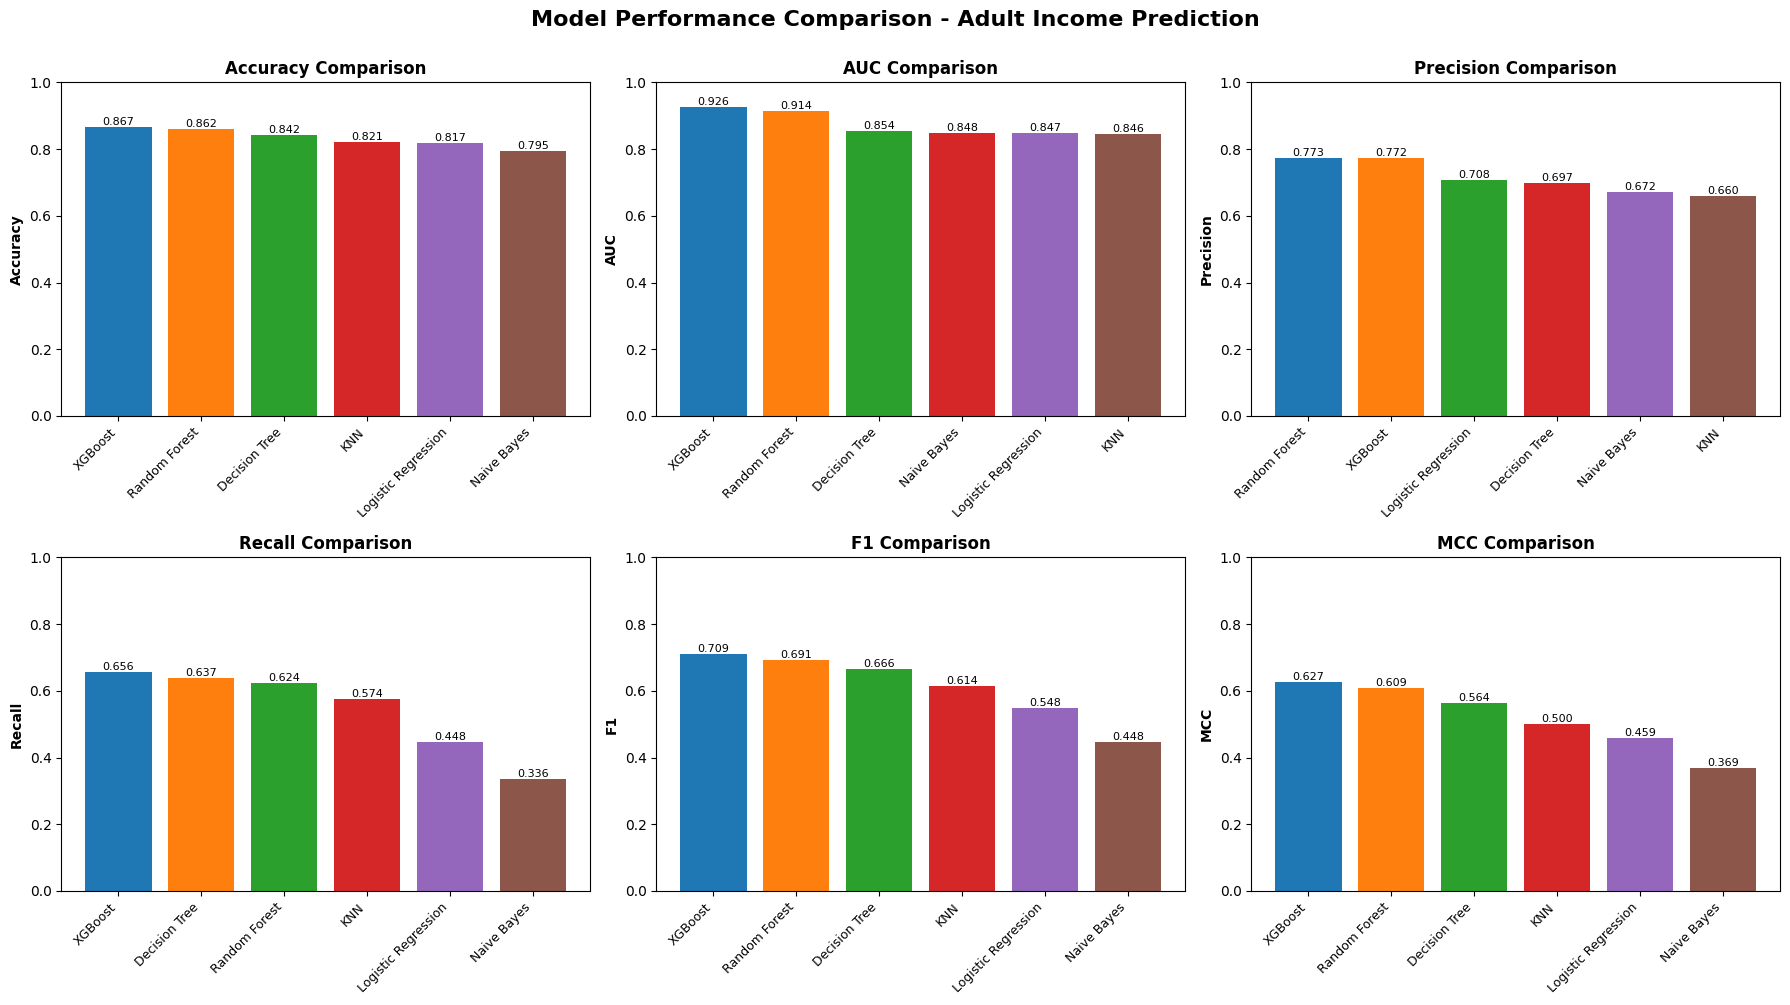

✓ Performance comparison visualizations created!


In [15]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison - Adult Income Prediction', 
             fontsize=16, fontweight='bold', y=1.00)

metrics = ['Accuracy', 'AUC', 'Precision', 'Recall', 'F1', 'MCC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    values = results_df[metric].sort_values(ascending=False)
    bars = ax.bar(range(len(values)), values.values, color=colors)
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(values.index, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel(metric, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("✓ Performance comparison visualizations created!")

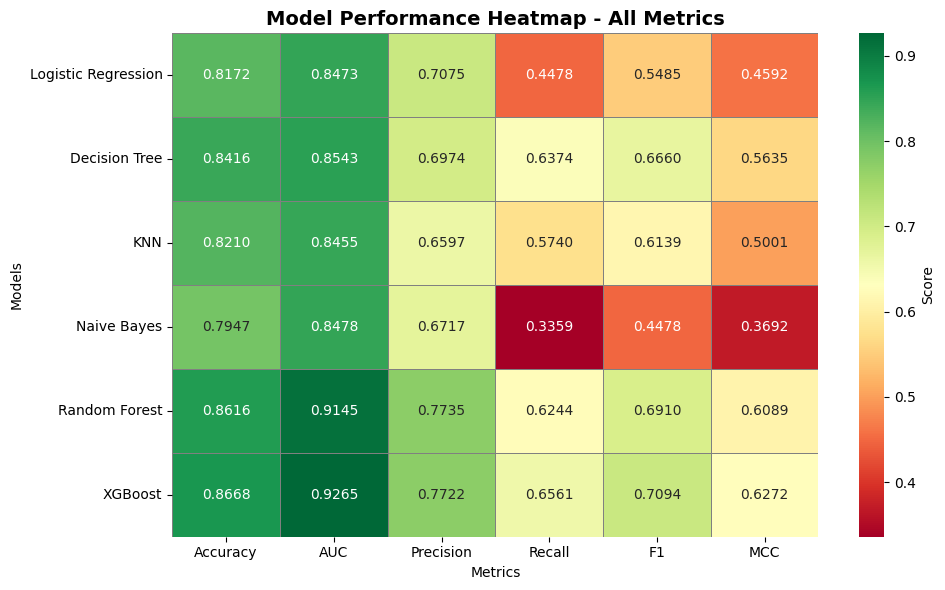

✓ Heatmap visualization created!


In [16]:
# Create heatmap for better comparison
plt.figure(figsize=(10, 6))
sns.heatmap(results_df, annot=True, fmt='.4f', cmap='RdYlGn', 
            cbar_kws={'label': 'Score'}, linewidths=0.5, linecolor='gray')
plt.title('Model Performance Heatmap - All Metrics', fontsize=14, fontweight='bold')
plt.xlabel('Metrics')
plt.ylabel('Models')
plt.tight_layout()
plt.show()

print("✓ Heatmap visualization created!")